In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 12.3.0


# CFAR

This example introduces constant false alarm rate (CFAR) detection and shows how to use [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to perform Cell-Averaging CFAR (`CA-CFAR`) detection and Ordered Statistics CFAR (`OS-CFAR`) detection.

## Introduction

CFAR stands for "Constant False Alarm Rate." It's a concept commonly used in radar signal processing and detection theory. CFAR is a technique that helps radar systems automatically adjust their detection thresholds based on the prevailing noise level in the environment, while maintaining a consistent probability of false alarms.

In radar systems, the goal is to detect targets (such as airplanes, ships, or weather phenomena) while minimizing false alarms caused by noise or clutter in the radar returns. CFAR algorithms enable the radar to adapt its threshold for target detection based on the statistical characteristics of the background noise, which can vary due to factors like weather conditions, terrain, and other environmental variables.

Here's how CFAR works:

1. **Estimation of Background Noise Level**: CFAR algorithms estimate the statistical properties of the background noise by analyzing the radar returns in a designated area where no targets are expected. This can involve calculating the mean and variance of the received signal's power.

2. **Threshold Calculation**: Once the background noise level is estimated, the CFAR algorithm calculates a detection threshold that corresponds to a constant probability of false alarms. The probability of false alarms is usually specified as a certain value (e.g., 1 false alarm per hour).

3. **Adaptive Thresholding**: As the radar scans its environment, the CFAR algorithm adjusts the detection threshold based on the estimated background noise level. This allows the radar to maintain a relatively constant false alarm rate across different operating conditions.

The advantage of CFAR is that it allows radar systems to be more adaptive and reliable in various environments. It ensures that the system doesn't produce an excessive number of false alarms when operating in noisy or cluttered conditions, while still detecting actual targets effectively.

CFAR techniques can vary depending on the specific radar system and its requirements. Popular CFAR methods include Cell Averaging CFAR (CA-CFAR), Order Statistic CFAR (OS-CFAR), and Greatest-of CFAR (GO-CFAR), among others. Each of these methods employs different statistical approaches to achieve the constant false alarm rate behavior.

## Create Radar Model

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter

Setup the basic transmitter parameters through [Transmitter](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter) module.

#### Define a Transmitter Channel

Here, only the location of the transmitter channel is defined at [0, 0, 0] m. All the other properties, such as `polarization`, `antenna patterns`, and `modulation`, etc, are using default values as listed in the [documentation](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter).


In [3]:
tx_channel = dict(location=(0, 0, 0))

#### Define a Radar Transmitter

As shown in the diagram below, `f` and `t` are used to define the waveform modulation. For a linear frequency-modulated continuous waveform (FMCW), it can be specified as `f = [fstart, fend]` and `t = [tstart, tend]`. If `t` is a single number `t = t0`, which is equivalent to `t = [0, t0]`. The bandwidth of the FMCW is `abs(fstart - fend)`. `prp` is the pulse repetition period, and `prp >= (tend - tstart)`.

```
|                       prp
|                  +-----------+
|
|            +---f[1]--->  /            /            /
|                         /            /            /
|                        /            /            /
|                       /            /            /
|                      /            /            /     ...
|                     /            /            /
|                    /            /            /
|                   /            /            /
|      +---f[0]--->/            /            /
|
|                  +-------+
|                 t[0]    t[1]
```


In [4]:
tx = Transmitter(
    f=[24.075e9, 24.175e9],
    t=80e-6,
    tx_power=30,
    prp=100e-6,
    pulses=1,
    channels=[tx_channel],
)

### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

#### Define a Receiver Channel

Similar to the transmitter channel, only the location of the receiver channel is defined at [0, 0, 0] m. All the other properties, such as `polarization`, `antenna patterns`, are using default values as listed in the [documentation](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver).


In [5]:
rx_channel = dict(location=(0, 0, 0))

#### Define a Radar Receiver

- `fs` – Sampling rate (sps)
- `noise_figure` – Noise figure (dB)
- `rf_gain` – Total RF gain (dB)
- `load_resistor` – Load resistor to convert power to voltage (Ohm)
- `baseband_gain` – Total baseband gain (dB)


In [6]:
rx = Receiver(
    fs=2e6,
    noise_figure=6,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=[rx_channel],
)

### Radar System

Use the defined transmitter and receiver to create the radar system.


In [7]:
radar = Radar(transmitter=tx, receiver=rx)

### Targets

The propertities of targets are defined here. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (degree).


In [8]:
target_1 = dict(location=(95, 20, 0), speed=(-50, 0, 0), rcs=20, phase=0)
target_2 = dict(location=(30, -5, 0), speed=(-22, 0, 0), rcs=10, phase=0)

targets = [target_1, target_2]

## Simulate Baseband Signals

Use the `simulator.simc` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [9]:
from radarsimpy.simulator import simc

data = simc(radar, targets)
timestamp = data["timestamp"]
baseband = data["baseband"]

_Plot the baseband samples_


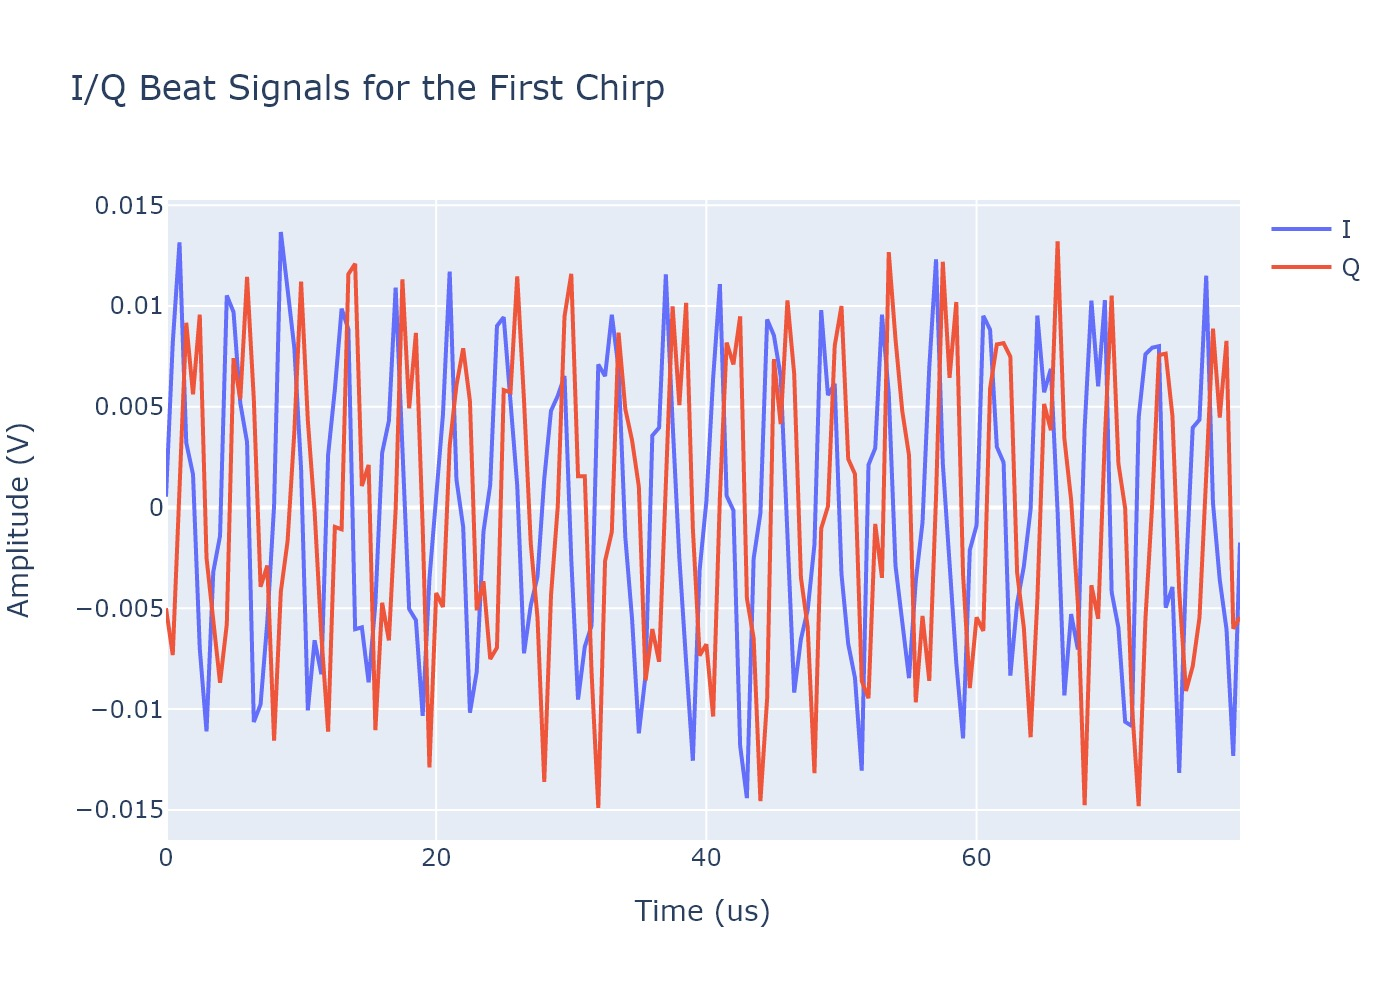

In [10]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :] * 1e6,
        y=np.real(baseband[0, 0, :]),
        name="I",
    )
)
fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :] * 1e6,
        y=np.imag(baseband[0, 0, :]),
        name="Q",
    )
)
fig.update_layout(
    title="I/Q Beat Signals for the First Chirp",
    yaxis=dict(title="Amplitude (V)"),
    xaxis=dict(title="Time (us)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Signal Processing

### Range Profile

With an FMCW radar, the range profile of the targets could be obtained through a simple FFT across the samples of the chirp. This process is also known as the range-FFT.


In [11]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)
range_profile = proc.range_fft(baseband, range_window)

### CFAR

The processing module of [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) incorporates both `CA-CFAR` and `OS-CFAR` algorithms. To calculate CFAR for 1-dimensional data, you can utilize the functions [cfar_ca_1d](https://radarsimx.github.io/radarsimpy/process.html#radarsimpy.processing.cfar_ca_1d) and [cfar_os_1d](https://radarsimx.github.io/radarsimpy/process.html#radarsimpy.processing.cfar_os_1d). On the other hand, for 2-dimensional data, you can make use of [cfar_ca_2d](https://radarsimx.github.io/radarsimpy/process.html#radarsimpy.processing.cfar_ca_2d) and [cfar_os_2d](https://radarsimx.github.io/radarsimpy/process.html#radarsimpy.processing.cfar_os_2d). This paragraph specifically focuses on demonstrating an example of 1-dimensional CFAR. However, if you are interested in exploring an example of 2-dimensional CFAR, you can refer to the [FMCW radar example](https://radarsimx.com/2021/05/10/fmcw-radar-with-a-corner-reflector/) available on the website.


In [12]:
ca_cfar = proc.cfar_ca_1d(
    np.abs(range_profile[0, 0, :]) ** 2,
    guard=2,
    trailing=10,
    pfa=1e-4,
    detector="squarelaw",
)
os_cfar = proc.cfar_os_1d(
    np.abs(range_profile[0, 0, :]) ** 2,
    guard=0,
    trailing=10,
    k=14,
    pfa=1e-4,
    detector="squarelaw",
)

_Plot range profile and CFAR_


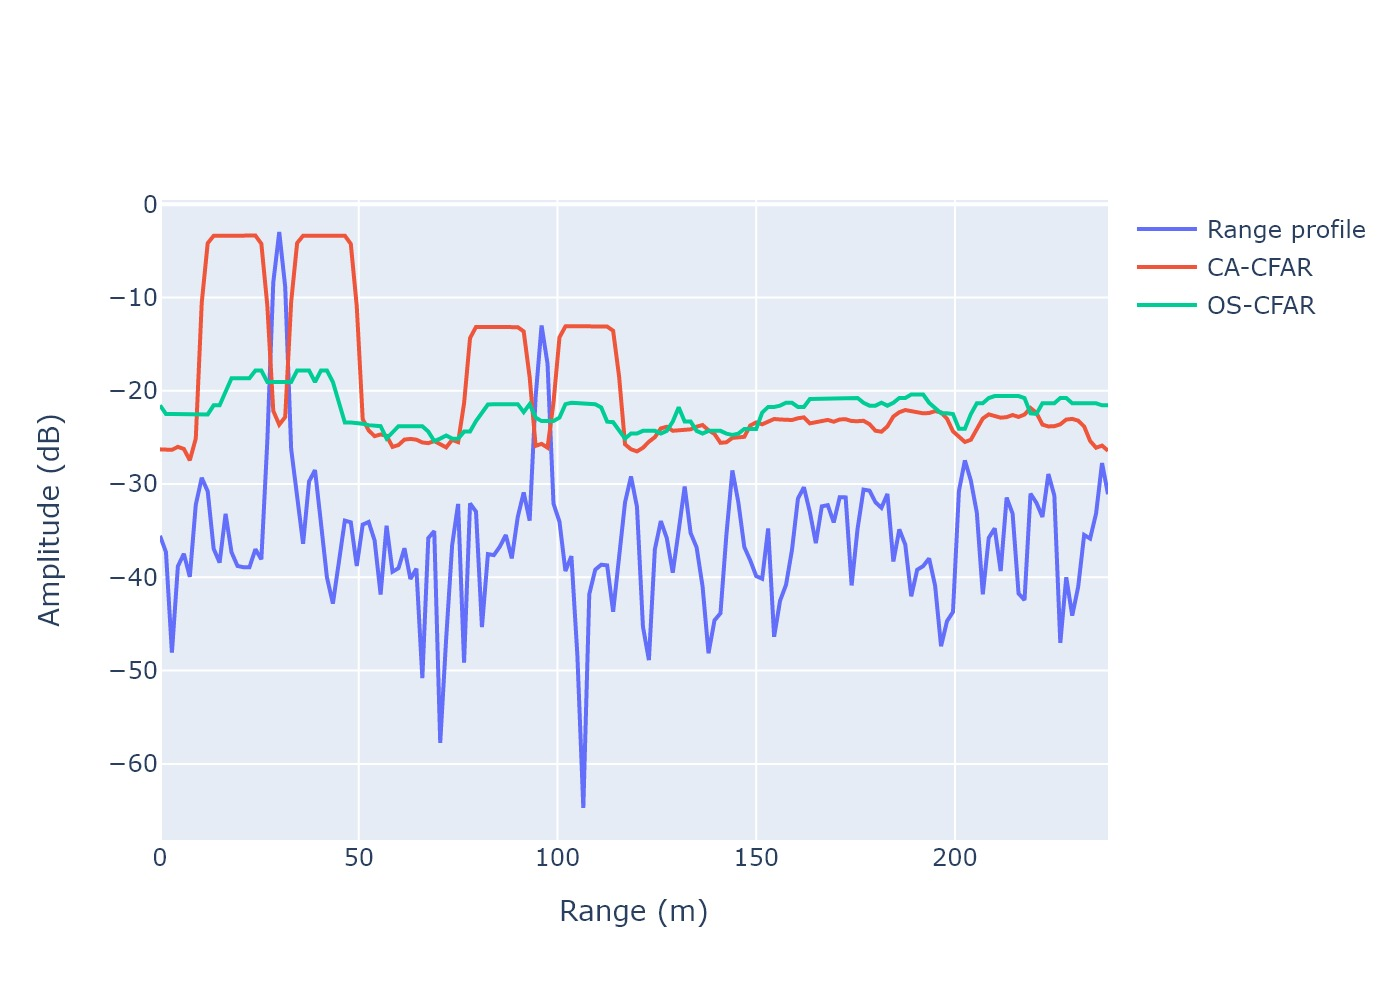

In [13]:
max_range = (
    3e8
    * radar.radar_prop["receiver"].bb_prop["fs"]
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 2
)
range_axis = np.linspace(
    0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False
)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(np.abs(range_profile[0, 0, :])),
        name="Range profile",
    )
)
fig.add_trace(go.Scatter(x=range_axis, y=10 * np.log10(ca_cfar), name="CA-CFAR"))
fig.add_trace(go.Scatter(x=range_axis, y=10 * np.log10(os_cfar), name="OS-CFAR"))
fig.update_layout(
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Range (m)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))